# Autoregressive Strategy Simulator

This notebook modifies the reset strategy from the ```ResetStrategyImplementer.py``` to use a more complex statistical model to dynamically set the center and width of the liquidity provision ranges  depending on recent behavriour of the market. For example, it will broaden the ranges when there have been recent large price movements, in order to ensure we are in range for longer, mitigating impermanent loss by reducing the concentration of liquidity. 

The statistical model embeds the concept of mean reversion, by allowing to forecast autoregressive term for the return, which shifs the center of the base and limit ranges in the direction that the model expects the price to go, hence the name ```AutoRegressiveStrategy```. This feature seeks to further increase the time spent in-range and mitigating impermanent loss.

The underlying model is a simple AR(1)-GARCH(1,1) model, which estimates the recent expected return and the volatility of the price based on recent observations. This new strategy is implemented in ```AutoRegressiveStrategyImplementer.py```.

Suppose that the price at time $t$ of the USDC-WETH 0.3% pool is $q_t$, then the price in USDC terms would be $p_t = 1/q_t$. The return is defined as $r_t = p_t / p_{t-1} - 1$, and this is the time series we model:

$$ r_t = c + \rho r_{t-1} + \sigma_t \varepsilon_t$$
$$ \sigma_t^2 = \omega + \alpha \varepsilon_{t-1} + \beta\sigma_{t-1}^2$$

For the strategy, we estimate the model only with the data that was available at that time, therefore making the simulations more realistic. Note that automatically setting bin width is part of the well-known Bollinger Bands strategy. Imposing a consistent statistical model gives more structure to the optimization problem, as well as allowing for forecasting and simulation more easily, which are part of our current plans.

In [1]:
import pandas as pd
import numpy as np
import GetPoolData
import AutoRegressiveStrategyImplementer
import itertools
import arch
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create config.py in this directory and enter your own Bitquery API Token
from config import BITQUERY_API_TOKEN

#################
#
# Download data
#
################

# Get Swap Data
DOWNLOAD_DATA      = False
address            = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
token_0_address    = '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48'
token_1_address    = '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2'


# Price data for theThese must be month ends
price_data_begin         = '2020-05-21'
price_data_end           = '2021-12-31'

swap_data  = GetPoolData.get_pool_data_flipside(address,BITQUERY_API_TOKEN,DOWNLOAD_DATA)  
price_data = GetPoolData.get_price_data_bitquery(token_0_address,token_1_address,price_data_begin,price_data_end,BITQUERY_API_TOKEN,DOWNLOAD_DATA)

## Model Evaluation

Let's assess how much does the predicted volatility vary over time, and how large are the standardized residuals of the estimated time series process. To compute returns we will be using a one-day interval, which implies that this will be the time horizon for each forecasting step that we do as well. Due to numerical concerns, the price return process is scaled up by a factor of 10, which must be taken into account when looking at the plots.

The plot shows these periods of relatively high volatility clusters ocurring peridiocally in the pool. The strategy will respond by wideining the bounds in these regimes, and narrowing them when the volatility cluster ends automatically. 

Additionally, we can see from the autocorrelation plot that there doesn't appear to be significant autocorrelation of the price return dataset, which as stated before are 1-day returns. The plot shows that even at the one-day frequency, knowing how ETH/USDC did today did not provide meaningful information about how it would do tomorrow, indicating that there will be limited impact from the AR(1) component of the model.

On the other hand, the model finds interesting time series structure in the volatility process, with relevant amounts of persistence in the variance itself, as can be seen by the $\beta=0.8701$ coefficient being highly significant.

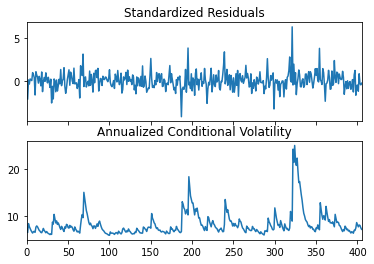

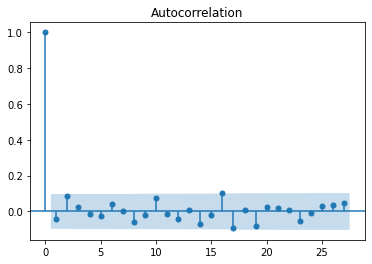

In [2]:
AGGREGATED_MINUTES  = 60*24 # Works like a 'target' rebalance period

price_data['price'] = price_data['close_price']
price_data_filtered = AutoRegressiveStrategyImplementer.aggregate_price_data(price_data,AGGREGATED_MINUTES)

ar                  = arch.univariate.ARX(price_data_filtered['price_return'].to_numpy()*10, lags=1)
ar.volatility       = arch.univariate.GARCH(p=1,q=1)
res                 = ar.fit(update_freq=0, disp="on")
fig                 = res.plot(annualize='D')

plot_acf(price_data_filtered['price_return'].to_numpy())
pyplot.show()

To further assess the impact of the autoregressive term, we run the model at different time frequencies beyond the one-day interval, to understand if the degree of aggregation is significantly impacting model estimation. In the next chart we fit the model for different values of frequency aggregation, with 1 standard deviation error bounds plotted as well.

The chart shows that at one minute frequencies you find a fairly negative coefficient, indicating that a period with a price increase is typically followed by one with a price decrease. However, at one minute frequencies model  estimation is subject to significant market microstructure noise, and thus the estimation results are unlikely to be useful for longer term price movement estimations. 

At 30 minute data frequency and above, the coefficient gets closer to zero as the magnitude of volatility $\sigma_t$ takes on a bigger impact at this frequency than the expected return, but $\beta$ is still relatively negative consistently. For the strategy simulation we will stick with the one-day estimation frequency to be consistent with prior work.

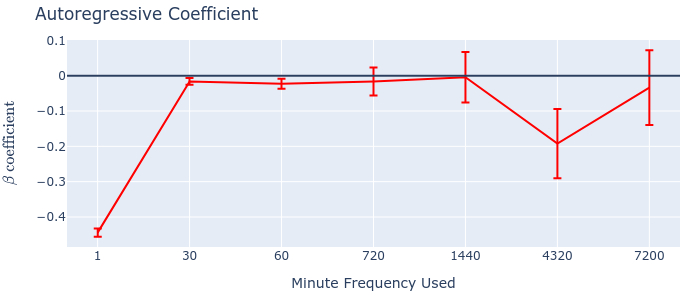

In [4]:
periods = [1, 30, 60, 60*12, 60*24, 60*24*3, 60*24*5]
ar_coefficient = []

for p in periods:
    price_data_filtered = AutoRegressiveStrategyImplementer.aggregate_price_data(price_data,p)
    ar_p                = arch.univariate.ARX(price_data_filtered['price_return'].to_numpy()*100, lags=1)
    ar_p.volatility     = arch.univariate.GARCH(p=1,q=1)
    res_p                 = ar_p.fit(update_freq=0, disp="on")
    ar_coefficient.append({
        'ar_coeff': res_p.params[1],
        'ar_std'  : res_p.std_err[1]
    })
    
ar_coefficient_pd = pd.DataFrame(ar_coefficient)

CHART_SIZE = 300

fig_ar_beta = go.Figure()

fig_ar_beta.add_trace(go.Scatter(
    x=list(periods), 
    y=ar_coefficient_pd['ar_coeff'],
    error_y=dict(
    type='data',
    array=ar_coefficient_pd['ar_std'],
    visible=True),
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#ff0000'))

fig_ar_beta.add_hline(y=0.0)

fig_ar_beta.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Autoregressive Coefficient',
    xaxis_title="Minute Frequency Used",
    yaxis_title=r'$\beta \text{ coefficient}$',
)

fig_ar_beta.update_xaxes(type='category')

fig_ar_beta.show(renderer="png")    

## Comparison with ResetStrategy

Our best performing parametrization of the ResetStrategy for the period July 15th — July 28th (```alpha_param = 0.95```, ```tau_param = 0.8```, ```and limit_param = 0.6```) had a Sharpe Ratio of 3.41. Let's see if we can do better with the more complex AutoRegressive Strategy. Preliminary testing informs that the $\alpha$ and $\tau$ ranges need to be wider in order to generate a good balance of rebalances and range coverage, as volatility adjusts dynamically in this model. 

This strategy requires a new parameter in the ```check_strategy``` step to assess if bounds need to be narrowed following a volatility spike, once it has subsided. It checks every hour whether current volatility is less than or equal to ```volatility_param``` percent relative to the last reset. We only need to do check when volatility goes down, as when volatility increases, it will cross a reset range that will indicate a rebalance, where the ranges will be automatically set according to current volatility.

### Evaluate Strategy

Let's study the strategy:  ```alpha_param = 0.9999```, ```tau_param = 0.99```, ```limit_param = 0.5``` & ```volatility_param = 0.5```. Let's plot the strategy and see what it looks like:

In [5]:
#################
#
# Run Auto Regressive Strategy
#
################

# Select date ranges for strategy simulation
DATE_BEGIN                 = pd.to_datetime('2021-07-15 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2021-07-28 00:00PM',utc=True)
price_data['price']        = price_data['close_price']
price_data['price_return'] = price_data['price'].pct_change()

# Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
STRATEGY_FREQUENCY         = 1 # (at least one minute)
simulate_data_filtered     = AutoRegressiveStrategyImplementer.aggregate_price_data(price_data,STRATEGY_FREQUENCY)
simulate_data_filtered     = simulate_data_filtered.drop(simulate_data_filtered[abs(simulate_data_filtered.price_return) > .05].index)
simulate_data_filtered     = simulate_data_filtered.sort_index()
simulate_data_price        = simulate_data_filtered[DATE_BEGIN:DATE_END]['price']

# Data for statistical analaysis (AGGREGATED_MINUTES frequency data)
AGGREGATED_MINUTES     = 60*24 
price_data['price']    = price_data['close_price']
price_data_filtered    = AutoRegressiveStrategyImplementer.aggregate_price_data(price_data,AGGREGATED_MINUTES)
price_data_filtered['price_return_scaled'] = price_data_filtered['price_return']*10


# Initial Position Details
INITIAL_TOKEN_0            = 100000
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0
FEE_TIER                   = 0.003

# Set decimals according to your pool
DECIMALS_0 = 6
DECIMALS_1 = 18

# Strategy Parameters
alpha_range    = [.99,.9999]
tau_range      = [.99,.9999]
limit_range    = [.5]
vol_range      = [.5]
results        = []
results_data   = []

for j in list(itertools.product(alpha_range,tau_range,limit_range,vol_range)):
    print(j)
    simulated_strategy               = AutoRegressiveStrategyImplementer.run_autoreg_strategy(simulate_data_price,swap_data,price_data_filtered,j[0],j[1],j[2],j[3],INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)                                      
    data_strategy                    = pd.DataFrame([i.dict_components() for i in simulated_strategy])
    data_strategy                    = data_strategy.set_index('time',drop=False)
    data_strategy                    = data_strategy.sort_index()
    data_strategy['cum_fees_usd']    = data_strategy['token_0_fees'].cumsum() + (data_strategy['token_1_fees'] * data_strategy['price_1_0']).cumsum()
    strat_result                     = AutoRegressiveStrategyImplementer.analyze_strategy(data_strategy,INITIAL_POSITION_VALUE)
    strat_result['alpha_param']      = j[0]
    strat_result['tau_param']        = j[1]
    strat_result['limit_param']      = j[2]
    strat_result['volatility_param'] = j[3]
    results_data.append(simulated_strategy)
    results.append(strat_result)
    
    
pd.DataFrame(results)

(0.99, 0.99, 0.5, 0.5)
(0.99, 0.9999, 0.5, 0.5)
(0.9999, 0.99, 0.5, 0.5)
(0.9999, 0.9999, 0.5, 0.5)


,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,volatility,sharpe_ratio,mean_base_position,median_base_position,alpha_param,tau_param,limit_param,volatility_param
0,13,1.075521,0.038306,1.358603,0.048389,6,0.119971,0.484527,2.803978,0.767559,0.881907,0.9900,0.9900,0.5,0.5
1,13,1.357978,0.048366,0.882393,0.031428,8,0.110161,0.527698,1.672156,0.847668,0.882278,0.9900,0.9999,0.5,0.5
2,13,0.775989,0.027638,1.854391,0.066047,6,0.127459,0.483208,3.837666,0.804422,0.875818,0.9999,0.9900,0.5,0.5
3,13,0.902616,0.032148,1.617287,0.057602,12,0.121742,0.497693,3.249566,0.845284,0.876211,0.9999,0.9999,0.5,0.5


This strategy can generate for the small parameter space studied here can lead to a 12.5% improvement in Sharpe Ratio, up to 3.84. Let's see what the strategy looks like in the following plot. It seems that the ranges set by this strategy were quite wide, and most of the rebalances occurred in a brief period of time in late July.

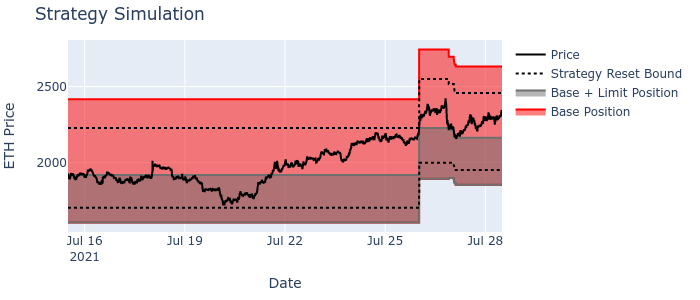

In [7]:
SELECTED_STRATEGY                    = 2
resulting_strat                      = results_data[SELECTED_STRATEGY]
data_strategy                        = pd.DataFrame([i.dict_components() for i in resulting_strat])
data_strategy                        = data_strategy.set_index('time',drop=False)
data_strategy                        = data_strategy.sort_index()
data_strategy['value_hold']          = INITIAL_TOKEN_0 + INITIAL_TOKEN_1 * data_strategy['price_1_0']
data_strategy['relative_to_holding'] = data_strategy['value_position']/data_strategy['value_hold']-1
data_strategy['cum_fees_usd']        = data_strategy['token_0_fees'].cumsum() + (data_strategy['token_1_fees'] * data_strategy['price_1_0']).cumsum()
data_strategy['net_gain']            = (data_strategy['value_position']  - INITIAL_POSITION_VALUE)/INITIAL_POSITION_VALUE

import plotly.graph_objects as go
from plotly.subplots import make_subplots

CHART_SIZE = 300

fig_strategy = go.Figure()
fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['base_range_lower_usd'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#ff0000',
    ))
fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['base_range_upper_usd'],
    name='Base Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#ff0000',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['limit_range_lower_usd'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#6f6f6f'))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['limit_range_upper_usd'],
    name='Base + Limit Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#6f6f6f',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['reset_range_lower_usd'],
    name='Strategy Reset Bound',
    line=dict(width=2,dash='dot',color='black')))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['reset_range_upper_usd'],
    showlegend = False,
    line=dict(width=2,dash='dot',color='black',)))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy['time'], 
    y=data_strategy['price_1_0'],
    name='Price',
    line=dict(width=2,color='black')))

fig_strategy.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Strategy Simulation',
    xaxis_title="Date",
    yaxis_title="ETH Price",
)

fig_strategy.show(renderer="png")

# Longer Period Estimation

In this section we will evaluate the strategy over a longer and more recent time period, July 1st to August 10 2021, and compare the rebalances and performance over the same time period.

As you can see, the Sharpe ratio for the Autoregressive Strategy is a healthy 1.32, whereas the prior optimal reset strategy provides negative returns.

In [21]:
#################
#
# Run Auto Regressive Strategy
#
################

# Select date ranges for strategy simulation
DATE_BEGIN                 = pd.to_datetime('2021-07-01 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2021-08-10 00:00PM',utc=True)
price_data['price']        = price_data['close_price']
price_data['price_return'] = price_data['price'].pct_change()

# Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
STRATEGY_FREQUENCY         = 1 # (at least one minute)
simulate_data_filtered     = AutoRegressiveStrategyImplementer.aggregate_price_data(price_data,STRATEGY_FREQUENCY)
simulate_data_filtered     = simulate_data_filtered.drop(simulate_data_filtered[abs(simulate_data_filtered.price_return) > .05].index)
simulate_data_filtered     = simulate_data_filtered.sort_index()
simulate_data_price        = simulate_data_filtered[DATE_BEGIN:DATE_END]['price']

# Data for statistical analaysis (AGGREGATED_MINUTES frequency data)
AGGREGATED_MINUTES         = 60*24 # Works like a 'target' rebalance period
price_data_filtered        = AutoRegressiveStrategyImplementer.aggregate_price_data(price_data,AGGREGATED_MINUTES)
price_data_filtered        = price_data_filtered.sort_index()

# Initial Position Details
INITIAL_TOKEN_0            = 100000
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0
FEE_TIER                   = 0.003

# Set decimals according to your pool
DECIMALS_0 = 6
DECIMALS_1 = 18

# Strategy Parameters
alpha_param    = .9999
tau_param      = .99
limit_param    = .5
vol_param      = .5

# Simulate strategy
simulated_strategy                        = AutoRegressiveStrategyImplementer.run_autoreg_strategy(simulate_data_price,swap_data,price_data_filtered,alpha_param,tau_param,limit_param,vol_param,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)                                      
data_strategy_long                        = pd.DataFrame([i.dict_components() for i in simulated_strategy])
data_strategy_long                        = data_strategy_long.set_index('time',drop=False)
data_strategy_long                        = data_strategy_long.sort_index()
data_strategy_long['value_hold']          = INITIAL_TOKEN_0 + INITIAL_TOKEN_1 * data_strategy_long['price_1_0']
data_strategy_long['relative_to_holding'] = data_strategy_long['value_position']/data_strategy_long['value_hold']-1
data_strategy_long['cum_fees_usd']        = data_strategy_long['token_0_fees'].cumsum() + (data_strategy_long['token_1_fees'] * data_strategy_long['price_1_0']).cumsum()
data_strategy_long['net_gain']            = (data_strategy_long['value_position']  - INITIAL_POSITION_VALUE)/INITIAL_POSITION_VALUE
pd.DataFrame([AutoRegressiveStrategyImplementer.analyze_strategy(data_strategy_long,INITIAL_POSITION_VALUE)])
    

,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,max_drawdown,volatility,sharpe_ratio,mean_base_position,median_base_position
0,40,1.01911,0.111683,0.673921,0.073854,24,0.211881,0.511407,1.317778,0.569798,0.541643


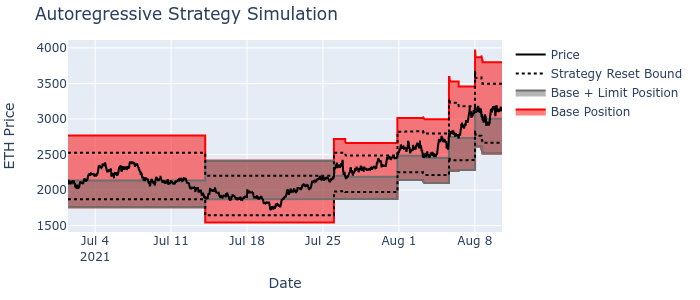

In [22]:
CHART_SIZE = 300

fig_strategy = go.Figure()
fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=data_strategy_long['base_range_lower_usd'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#ff0000',
    ))
fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=data_strategy_long['base_range_upper_usd'],
    name='Base Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#ff0000',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=data_strategy_long['limit_range_lower_usd'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#6f6f6f'))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=data_strategy_long['limit_range_upper_usd'],
    name='Base + Limit Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#6f6f6f',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=data_strategy_long['reset_range_lower_usd'],
    name='Strategy Reset Bound',
    line=dict(width=2,dash='dot',color='black')))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=data_strategy_long['reset_range_upper_usd'],
    showlegend = False,
    line=dict(width=2,dash='dot',color='black',)))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_long['time'], 
    y=data_strategy_long['price_1_0'],
    name='Price',
    line=dict(width=2,color='black')))

fig_strategy.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Autoregressive Strategy Simulation',
    xaxis_title="Date",
    yaxis_title="ETH Price",
)

fig_strategy.show(renderer="png")

In [ ]:
#################
#
# Run Reset Strategy
#
################

import ResetStrategyImplementer
from statsmodels.distributions.empirical_distribution import ECDF, monotone_fn_inverter

# Select date ranges for strategy simulation
DATE_BEGIN                 = pd.to_datetime('2021-07-01 00:00PM',utc=True)
DATE_END                   = pd.to_datetime('2021-08-10 00:00PM',utc=True)
price_data['price']        = price_data['close_price']
price_data['price_return'] = price_data['price'].pct_change()

# Data for strategy simulation. We can use aggregate_price_data to analyze the strategy at a coarser STRATEGY_FREQUENCY in minutes
STRATEGY_FREQUENCY         = 1 # (at least one minute)
simulate_data_filtered     = ResetStrategyImplementer.aggregate_price_data(price_data,STRATEGY_FREQUENCY)
simulate_data_filtered     = simulate_data_filtered.drop(simulate_data_filtered[abs(simulate_data_filtered.price_return) > .05].index)
simulate_data_filtered     = simulate_data_filtered.sort_index()
simulate_data_price        = simulate_data_filtered[DATE_BEGIN:DATE_END]['price']

# Data for statistical analaysis (AGGREGATED_MINUTES frequency data)
AGGREGATED_MINUTES         = 60*24 # Works like a 'target' rebalance period
price_data_filtered        = ResetStrategyImplementer.aggregate_price_data(price_data,AGGREGATED_MINUTES)
ecdf                       = ECDF(price_data_filtered['price_return'].to_numpy())
ecdf_inv                   = monotone_fn_inverter(ecdf,np.linspace(price_data_filtered['price_return'].min(),price_data_filtered['price_return'].max(),1000),vectorized=False)

# Initial Position Details
INITIAL_TOKEN_0            = 100000
INITIAL_TOKEN_1            = INITIAL_TOKEN_0*simulate_data_price[0]
INITIAL_POSITION_VALUE     = 2*INITIAL_TOKEN_0
FEE_TIER                   = 0.003

# Set decimals according to your pool
DECIMALS_0  = 6
DECIMALS_1  = 18

# Strategy Parameters
alpha_param = .95
tau_param   = .80
limit_param = .50

simulated_strategy                   = ResetStrategyImplementer.run_reset_strategy(simulate_data_price,swap_data,alpha_param,tau_param,limit_param,ecdf,ecdf_inv,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)
data_strategy_reset                  = pd.DataFrame([i.dict_components() for i in simulated_strategy])
data_strategy_reset                  = data_strategy_reset.set_index('time',drop=False)
data_strategy_reset                  = data_strategy_reset.sort_index()
data_strategy_reset['cum_fees_usd']  = data_strategy_reset['token_0_fees'].cumsum() + (data_strategy_reset['token_1_fees'] * data_strategy_reset['price_1_0']).cumsum()

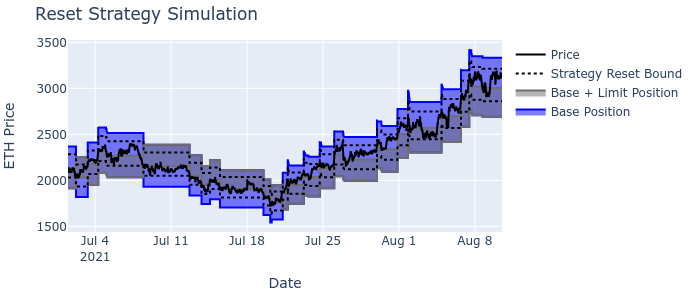

{'days_strategy': 40,
 'gross_fee_apr': 1.1083782996025504,
 'gross_fee_return': 0.12146611502493702,
 'net_apr': -0.42960882203889267,
 'net_return': -0.04708041885357728,
 'rebalances': 65,
 'max_drawdown': 0.19653287474323392,
 'volatility': 0.5054095795251555,
 'sharpe_ratio': -0.850021130273234,
 'mean_base_position': 0.5547527362943753,
 'median_base_position': 0.5933157678529959}

In [20]:
CHART_SIZE = 300

fig_strategy = go.Figure()
fig_strategy.add_trace(go.Scatter(
    x=data_strategy_reset['time'], 
    y=data_strategy_reset['base_range_lower_usd'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#0000FF',
    ))
fig_strategy.add_trace(go.Scatter(
    x=data_strategy_reset['time'], 
    y=data_strategy_reset['base_range_upper_usd'],
    name='Base Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#0000FF',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_reset['time'], 
    y=data_strategy_reset['limit_range_lower_usd'],
    fill=None,
    mode='lines',
    showlegend = False,
    line_color='#6f6f6f'))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_reset['time'], 
    y=data_strategy_reset['limit_range_upper_usd'],
    name='Base + Limit Position',
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='#6f6f6f',))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_reset['time'], 
    y=data_strategy_reset['reset_range_lower_usd'],
    name='Strategy Reset Bound',
    line=dict(width=2,dash='dot',color='black')))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_reset['time'], 
    y=data_strategy_reset['reset_range_upper_usd'],
    showlegend = False,
    line=dict(width=2,dash='dot',color='black',)))

fig_strategy.add_trace(go.Scatter(
    x=data_strategy_reset['time'], 
    y=data_strategy_reset['price_1_0'],
    name='Price',
    line=dict(width=2,color='black')))

fig_strategy.update_layout(
    margin=dict(l=20, r=20, t=40, b=20),
    height= CHART_SIZE,
    title = 'Reset Strategy Simulation',
    xaxis_title="Date",
    yaxis_title="ETH Price",
)

fig_strategy.show(renderer="png")

ResetStrategyImplementer.analyze_strategy(data_strategy_reset,INITIAL_POSITION_VALUE)

To see more precisely what is going on, we can see that was the volatility, and expected future returns which shifted and expanded the range vs. a simpler reset strategy:

<AxesSubplot:xlabel='time'>

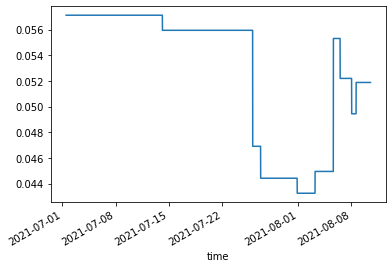

In [25]:
data_strategy_long.volatility.plot()

<AxesSubplot:xlabel='time'>

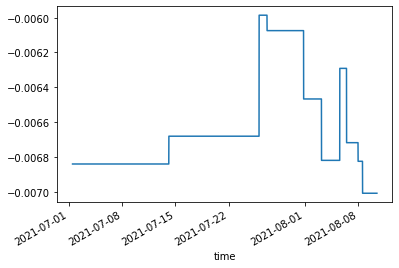

In [27]:
data_strategy_long.return_forecast.plot()